# Urban Heat Island (UHI) Analysis & Mitigation Planner

## 1. Introduction

**Objective**: Map Nairobi's urban heat islands using satellite data and propose green infrastructure solutions.

In [1]:
# Installing the required packages
!pip install earthengine-api
!pip install geemap
!pip install geopandas
!pip install rasterio
!pip install folium
!pip install leafmap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 72.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 518.7/518.7 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.1/219.1 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 86.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 85.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 765.5/765.5 kB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.2/194.2 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.0/74.0 kB 5.9 MB/s eta 0:00:00


In [2]:
import ee
import geemap

# Authenticate and initialize GEE
ee.Authenticate()
ee.Initialize(project='gacheri') #required to specify project name

In [3]:
# import other libraries
import numpy as np
import pandas as pd
import geopandas as gpd
from datetime import datetime

In [4]:
# Our Study Area is Nairobi Metropolitan
# Define Nairobi Metropolitan Area
nairobi_coords = [
    [36.6108, -1.0962],
    [37.1237, -1.0962],
    [37.1237, -1.4895],
    [36.6108, -1.4895],
    [36.6108, -1.0962]
]
aoi = ee.Geometry.Polygon([nairobi_coords]) #roi = region of interest

## 2. Data Collection

# We now begin our LST analysis; using seasonal variations to calculate and visualize the Land Surface Temperatures for Nairobi.
In Nairobi, typically the rainfall patterns are as follows:
Long rains: March to May

*   Long rains: March to May
*   Short rains: October to December
*   Dry seasons: January-February and June-September

In [5]:
# Define the seasons
seasons = {
    'Dry Season 1 (Jan-Feb)': {'months': [1, 2], 'max_cloud_cover': 15},
    'Long Rains (Mar-May)': {'months': [3, 4, 5], 'max_cloud_cover': 35}, # More lenient as there's no images @ <20 cover
    'Dry Season 2 (Jun-Sep)': {'months': [6, 7, 8, 9], 'max_cloud_cover': 15},
    'Short Rains (Oct-Dec)': {'months': [10, 11, 12], 'max_cloud_cover': 20}
}

Applying a scale factor involves adjusting pixel values in satellite imagery to ensure they represent physical properties accurately. For example, it’s used to convert digital numbers into physical units, like radiance or reflectance, making the data more meaningful for analysis.

In [6]:
# Define the start and end years
start_year = 2021
end_year = 2023

# Define a function to apply scaling factors to the Landsat 8 bands
def apply_scale_factors(image):
    # Scale and offset values for optical bands
    optical_bands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    # Scale and offset values for thermal bands
    thermal_bands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
    # Add scaled bands to the original image
    return image.addBands(optical_bands, None, True).addBands(thermal_bands, None, True)

Cloud masking is a process to identify and remove cloud-affected pixels from satellite imagery. It’s essential for ensuring that the analysis focuses on clear and cloud-free areas, minimizing the impact of clouds and their shadows on the results.

In [7]:
# Define a function to mask clouds and cloud shadows
def cloud_mask(image):
    # Define cloud shadow and cloud bitmasks (Bits 3 and 5)
    cloud_shadow_bitmask = (1 << 3)
    cloud_bitmask = (1 << 5)
    # Select the Quality Assessment (QA) band for pixel quality information
    qa = image.select('QA_PIXEL')
    # Create a binary mask to identify clear conditions (both cloud and cloud shadow bits set to 0)
    mask = qa.bitwiseAnd(cloud_shadow_bitmask).eq(0).And(qa.bitwiseAnd(cloud_bitmask).eq(0))
    # Update the original image, masking out cloud and cloud shadow-affected pixels
    return image.updateMask(mask)

Calculate NDVI, Proportion of Vegetation, Emissivity

Step 4.1. Calculate NDVI

NDVI (Normalized Difference Vegetation Index) is a widely used vegetation index in remote sensing and environmental science. It quantifies the presence and health of vegetation based on the reflectance of visible and near-infrared light. NDVI values typically range from -1 to 1, with higher values indicating healthier or denser vegetation.

NDVI is calculated using the following formula:

NDVI=(NIR+Red)/(NIR−Red)​

NIR (Near-Infrared) is the reflectance in the near-infrared part of the electromagnetic spectrum (typically Landsat band 5 or similar).
Red is the reflectance in the red part of the spectrum (typically Landsat band 4 or similar).

Calculate Proportion of Vegetation (PV) and Emissivity (EM)

The proportion of vegetation cover is calculated using the following formula:

Proportion of Vegetation (PV) = (NDVI — NDVI_min) / (NDVI_max — NDVI_min)

Where:

NDVI represents the pixel’s NDVI value.
NDVI_min is the minimum NDVI value specified.
NDVI_max is the maximum NDVI value specified.

The Proportion of Vegetation (PV) is a metric used to quantify the relative abundance of vegetation within a specified area by analyzing Normalized Difference Vegetation Index (NDVI) values. It provides valuable insights into land cover and ecosystem health, with higher PV values indicating a greater presence of vegetation. On the other hand, Emissivity (EM) is a critical parameter for accurate Land Surface Temperature (LST) calculations. In the provided code, EM is computed as a function of PV, reflecting how efficiently a surface emits thermal radiation. EM values near 1.0 are typical for natural surfaces like soil and vegetation, while lower values are often associated with water bodies or urban areas. Both PV and EM play essential roles in remote sensing and environmental studies, contributing to a more comprehensive understanding of land characteristics and thermal behavior.

**LST Estimation**

In [8]:
# Function to calculate LST
def calculate_lst(image):
    thermal = image.select('ST_B10')
    ndvi = image.normalizedDifference(['SR_B5', 'SR_B4'])

    # Calculate minimum and maximum NDVI values
    ndvi_min = ee.Number(ndvi.reduceRegion(
        reducer=ee.Reducer.min(),
        geometry=aoi,
        scale=30,
        maxPixels=1e9
    ).values().get(0))

    ndvi_max = ee.Number(ndvi.reduceRegion(
        reducer=ee.Reducer.max(),
        geometry=aoi,
        scale=30,
        maxPixels=1e9
    ).values().get(0))

    # Calculate Proportion of Vegetation (PV)
    fv = ((ndvi.subtract(ndvi_min)).divide(ndvi_max.subtract(ndvi_min))).pow(2).rename('FV')

    # Calculate Emissivity (EM)
    em = fv.multiply(0.004).add(0.986).rename('EM')

    # Calculate Land Surface Temperature (LST)
    lst = thermal.expression(
        '(TB / (1 + (0.00115 * (TB / 1.438)) * log(em))) - 273.15', {
            'TB': thermal.select('ST_B10'),
            'em': em
        }).rename('LST')

    return image.addBands(lst)

In [9]:
# Calculate seasonal LST
seasonal_lst = {}
for season_name, params in seasons.items():
    season_filter = ee.Filter.Or([
        ee.Filter.And(
            ee.Filter.calendarRange(year, year, 'year'),
            ee.Filter.calendarRange(params['months'][0], params['months'][-1], 'month')
        ) for year in range(start_year, end_year + 1)
    ])

    season_collection = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2") \
                           .filterBounds(aoi) \
                           .filterDate(f'{start_year}-01-01', f'{end_year}-12-31') \
                           .filter(season_filter) \
                           .filter(ee.Filter.lt('CLOUD_COVER', params['max_cloud_cover'])) \
                           .map(apply_scale_factors) \
                           .map(cloud_mask) \
                           .map(calculate_lst) \
                           .select('LST') \
                           .mean() \
                           .clip(aoi)

    seasonal_lst[season_name] = season_collection

**LST Visualization**

In [10]:
# Create a map centered on Nairobi
Map = geemap.Map(center=[-1.2921, 36.8219], zoom=11)
Map.add_basemap('HYBRID')

# Define visualization parameters for LST
lst_viz_params = {
    'min': 18.47,
    'max': 42.86,
    'palette': [
        '040274', '040281', '0502a3', '0502b8', '0502ce', '0502e6',
        '0602ff', '235cb1', '307ef3', '269db1', '30c8e2', '32d3ef',
        '3be285', '3ff38f', '86e26f', '3ae237', 'b5e22e', 'd6e21f',
        'fff705', 'ffd611', 'ffb613', 'ff8b13', 'ff6e08', 'ff500d',
        'ff0000', 'de0101', 'c21301', 'a71001', '911003'
    ]
}

# Add the seasonal LST layers to the map
for season_name, lst_image in seasonal_lst.items():
    Map.addLayer(lst_image, lst_viz_params, f'LST - {season_name}')

# Add a colorbar to the map for better interpretation of the LST values
Map.add_colorbar(lst_viz_params, label='Land Surface Temperature (°C)')

# Add a title to the map
Map.add_text(
    text="Land Surface Temperature (LST) in Nairobi Metropolitan Area",
    position = 'topleft',
    xy=('50%', '10px'),
    fontsize='20px',
    color='black',
    font_weight='bold',
    align='center'
)

# Display the map
Map

Map(center=[-1.2921, 36.8219], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDa…

## Spatial Variation in Land Surface Temperature (LST)

### North Western Areas (Towards Limuru)
The LST is generally lower in the northwestern parts of Nairobi Metropolitan Area, particularly towards Limuru. This pattern can be attributed to several factors:
- **Elevation**: Higher elevations in the northwestern region lead to cooler temperatures.
- **Vegetation Cover**: The presence of more vegetation in these areas helps to moderate surface temperatures by providing shade and promoting evaporative cooling.
- **Microclimates**: Local topography and land use patterns create microclimates that contribute to lower surface temperatures.

### South Eastern Areas (Towards Kitengela)
Conversely, the LST is higher in the southeastern parts, particularly towards Kitengela. This can be attributed to:
- **Lower Elevation**: Lower elevations in the southeastern region result in higher temperatures.
- **Urban Heat Island Effect**: Increased urbanization and impervious surfaces in these areas contribute to higher surface temperatures.
- **Less Vegetation**: Reduced vegetation cover leads to less evaporative cooling and higher surface temperatures.

## Seasonal Variation in LST

### Rainy Seasons
- **Long Rains (March-May)** and **Short Rains (October-December)**:
  - LST values are generally lower during the rainy seasons.
  - **Factors Contributing**:
    - **Increased Cloud Cover**: Clouds reflect solar radiation, reducing the amount of heat reaching the surface.
    - **Higher Humidity**: Increased moisture in the air helps to moderate temperatures.
    - **Frequent Precipitation**: Rainfall cools the surface directly and increases soil moisture, which enhances evaporative cooling.

### Dry Seasons
- **Dry Season 1 (January-February)** and **Dry Season 2 (June-September)**:
  - LST values are significantly higher during the dry seasons.
  - **Factors Contributing**:
    - **Clear Skies**: Lack of cloud cover allows more direct solar radiation to reach the surface, increasing temperatures.
    - **Low Humidity**: Dry air reduces the cooling effect of evaporation.
    - **Soil Dryness**: Dry soil absorbs more heat, leading to higher surface temperatures.





## 3. Correlating LST with Land Use

In [13]:
!pip install geopandas rtree #osm dependency
!pip install osmnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 543.2/543.2 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.6/99.6 kB 3.1 MB/s eta 0:00:00


In [18]:
#!pip install --upgrade osmnx

In [19]:
import osmnx as ox

osmnx expects a Shapely geometry or a GeoDataFrame for its geometries_from_polygon function; so let's convert our coordinates first.

In [20]:
from shapely.geometry import Polygon

# Create a Shapely Polygon from the coordinates
shapely_aoi = Polygon(nairobi_coords)

### Load Land Use Data from OSM Using the Shapely Geometry:
Use the features module to download geometries from OSM.

In [24]:
# Define the tags to load land use data
land_use_tags = {
    'landuse': True,
    'natural': True,
    'leisure': True,
    'water': True
}

# Load land use data from OSM using the Shapely geometry
land_use_gdf = ox.features_from_polygon(shapely_aoi, tags=land_use_tags)

# Simplify and filter the land use data
land_use_gdf['land_use_type'] = land_use_gdf['landuse'].fillna(land_use_gdf['natural']).fillna(land_use_gdf['leisure']).fillna(land_use_gdf['water'])
land_use_gdf = land_use_gdf[land_use_gdf['land_use_type'].notna()]

###Visualize the Land Use Data:
Visualize the land use data to ensure it covers your AOI correctly.

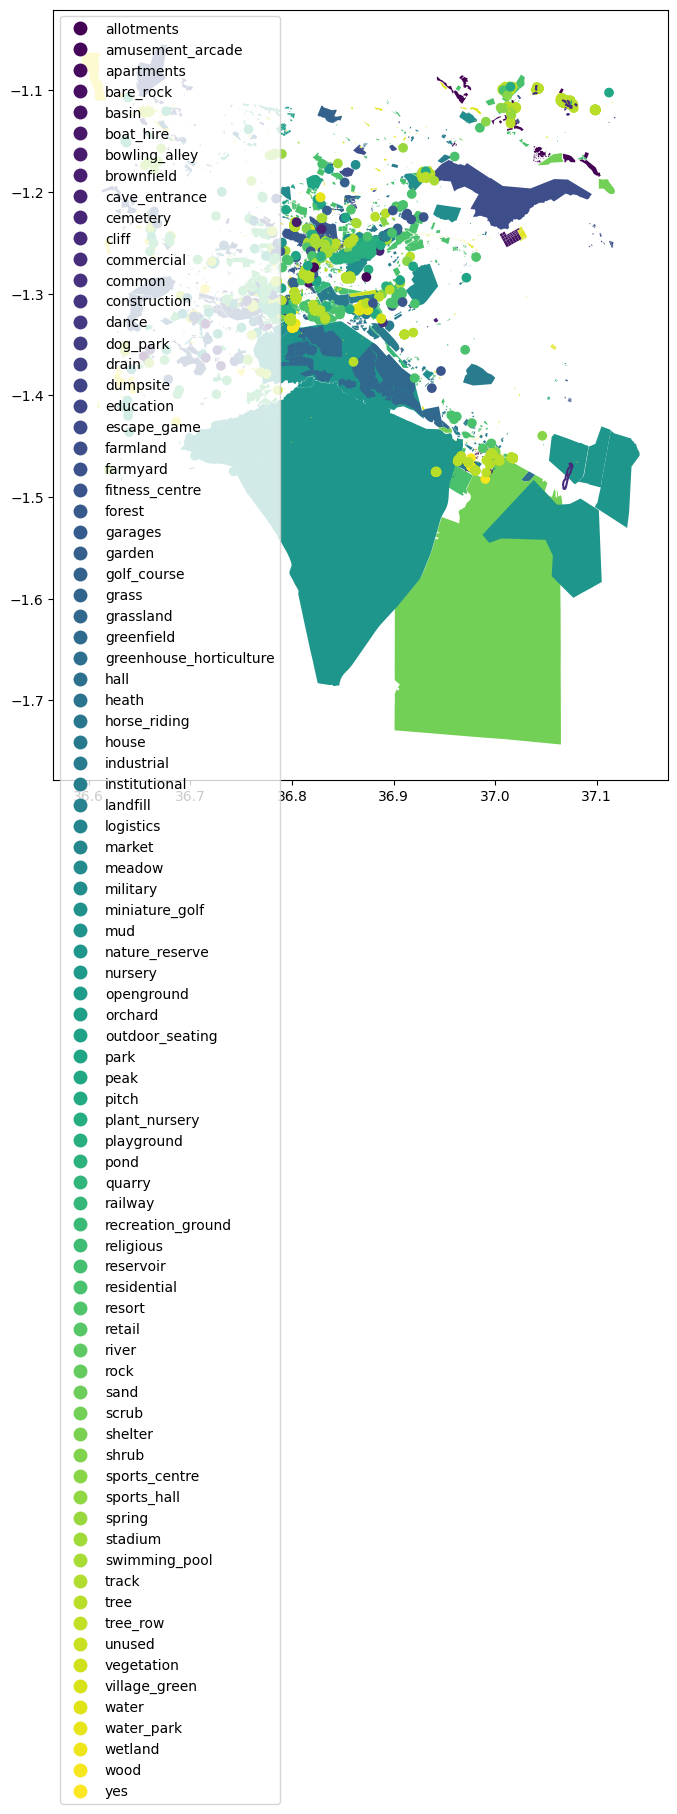

In [25]:
import matplotlib.pyplot as plt

# Plot the land use data
fig, ax = plt.subplots(figsize=(10, 10))
land_use_gdf.plot(ax=ax, column='land_use_type', legend=True, cmap='viridis')
plt.show()